## How transfer learning works:
<b>Part 1:</b> Train the Backbone
1. Train a CNN (for example Resnet) on a large scale dataset like ImageNet where it learns how to create useful feature maps.
    - This reduces image dimensions and increases the number of channels
2. Do some pooling on the feature maps, then flatten and input into fully connected layers that predict the 1000 categories of ImageNet

<b>Part 2:</b> Use Backbone to form final model.
1. Get rid of the last layer that predicts the 1000 categories of ImageNet and instead make the output just the number of neurons you need.
2. You can freeze the weights of the convolutional layers, if you do then this is called the feature extraction method.
3. Retrain on your data so the final fully connected layers improve.


In [32]:
# Imports

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy
from colored import Fore, Style


plt.ion()   # interactive mode, damn didnt even know this existed

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # use gpu if available

print(torch.cuda.is_available())
print(torch.__version__)

True
2.0.0+cu118


## Data Augmentation Techniques

- transforms.RandomResizedCrop(224):
    - New image is a random crop of original image of size 224x224
- transforms.RandomHorizontalFlip():
    - Image is transformed with a horizontal flip 50% of the time
- transforms.toTensor():
    - Just converts the 3 channel image into a Tensor
- transforms.Normalize():
    - 2 main Benifits:
        - Zero-Centering: Subtracting the mean of the pixel values makes the mean of the data approximately zero. This helps ensure that the network doesn't learn spurious biases based on the overall brightness or color of the images in the dataset.
        - Scaling: Dividing by the standard deviation scales the pixel values, making them have a roughly consistent magnitude. This can help the training process converge faster and be more numerically stable.




In [33]:
mean = np.array([0.485, 0.456, 0.406]) # mean of imagenet dataset
std = np.array([0.229, 0.224, 0.225])  # std of imagenet dataset

dataTransforms = {
    'train': 
        transforms.Compose([
        transforms.RandomResizedCrop(224),          # crop image to 224x224
        transforms.RandomHorizontalFlip(),          # flip image horizontally
        transforms.ToTensor(),                      # convert image to tensor
        transforms.Normalize(mean, std)]),          # normalize image
        
    'val': 
        transforms.Compose([
        transforms.Resize(256),                     # resize image to 256x256
        transforms.CenterCrop(224),                 # crop image to 224x224
        transforms.ToTensor(),                      # convert image to tensor
        transforms.Normalize(mean, std)]),          # normalize image
    
    'test': 
        transforms.Compose([
        transforms.Resize(256),                     # resize image to 256x256
        transforms.CenterCrop(224),                 # crop image to 224x224
        transforms.ToTensor(),                      # convert image to tensor
        transforms.Normalize(mean, std)]),          # normalize image
}

In [34]:
data_dir = 'dataset'
sets = ['train', 'val', 'test']

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), dataTransforms[x]) for x in sets} # create datasets
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in sets} # create dataloaders

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(image_datasets['train']) # Check if it worked


Dataset ImageFolder
    Number of datapoints: 600
    Root location: dataset\train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485 0.456 0.406], std=[0.229 0.224 0.225])
           )


### Ripped code for displaying data from Pytorch website: 

(228, 906, 3)
(228, 906, 3)


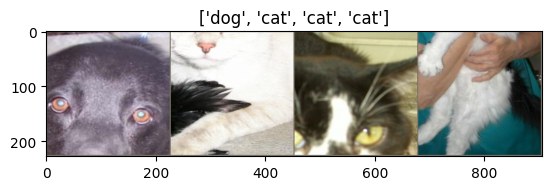

In [35]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    print(inp.shape)
    inp = std * inp + mean
    print(inp.shape)
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataLoader['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [36]:
def trainModel(model, epochs = 25):
    since = time.time()
    
    for epoch in range(epochs):
        # Print Epoch Number:
        print(f'{Fore.yellow}Epoch:{Style.reset} ', end="")
        print(f'{epoch+1}/{epochs}')
        print('—' * 10)
        
        
# trainModel("model")

In [37]:
tensor = torch.tensor([[-1, 2, 3], [4, -5, 6]])
print(tensor)
tensor = F.relu(tensor)
print(tensor)

print(F.relu_.__doc__)

tensor([[-1,  2,  3],
        [ 4, -5,  6]])
tensor([[0, 2, 3],
        [4, 0, 6]])

relu_(input) -> Tensor

In-place version of :func:`~relu`.



In [38]:
# dir(F)

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [40]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [41]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [42]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5707 Acc: 0.7467
val Loss: 0.1674 Acc: 0.9300

Epoch 1/24
----------
train Loss: 0.7116 Acc: 0.7533
val Loss: 0.1603 Acc: 0.9400

Epoch 2/24
----------
train Loss: 0.4569 Acc: 0.8133
val Loss: 0.1542 Acc: 0.9350

Epoch 3/24
----------
train Loss: 0.5683 Acc: 0.7767
val Loss: 0.3419 Acc: 0.8650

Epoch 4/24
----------
train Loss: 0.5643 Acc: 0.8100
val Loss: 0.1648 Acc: 0.9550

Epoch 5/24
----------
train Loss: 0.4916 Acc: 0.7967
val Loss: 0.1600 Acc: 0.9200

Epoch 6/24
----------
train Loss: 0.6055 Acc: 0.7867
val Loss: 0.2214 Acc: 0.9200

Epoch 7/24
----------
train Loss: 0.3887 Acc: 0.8300
val Loss: 0.1230 Acc: 0.9500

Epoch 8/24
----------
train Loss: 0.3172 Acc: 0.8617
val Loss: 0.1090 Acc: 0.9450

Epoch 9/24
----------
train Loss: 0.3183 Acc: 0.8717
val Loss: 0.1034 Acc: 0.9500

Epoch 10/24
----------
train Loss: 0.2966 Acc: 0.8733
val Loss: 0.1164 Acc: 0.9450

Epoch 11/24
----------
train Loss: 0.2939 Acc: 0.8800
val Loss: 0.1064 Acc: 0.9500

Ep

(224, 224, 3)
(224, 224, 3)


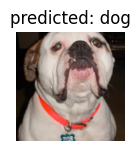

(224, 224, 3)
(224, 224, 3)


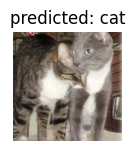

(224, 224, 3)
(224, 224, 3)


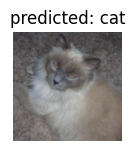

(224, 224, 3)
(224, 224, 3)


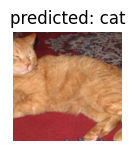

(224, 224, 3)
(224, 224, 3)


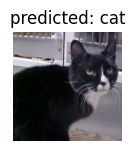

(224, 224, 3)
(224, 224, 3)


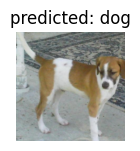

In [43]:
visualize_model(model_ft)